In [323]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
import io
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance

In [305]:
bucket_name = 'sagemaker-hremployeeattrition-0001' # <--- change this variable to a unique name for your bucket
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [306]:
### Load dataset from public dataset website 
try:
  urllib.request.urlretrieve ("https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-HR-Employee-Attrition.xlsx", "WA_Fn-UseC_-HR-Employee-Attrition.xlsx")
  print('Success: downloaded WA_Fn-UseC_-HR-Employee-Attrition.xlsx.')
except Exception as e:
  print('Data load error: ',e)

try:
  model_data = pd.read_csv('./WA_Fn-UseC_-HR-Employee-Attrition.xlsx',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded WA_Fn-UseC_-HR-Employee-Attrition.xlsx.
Data load error:  Error tokenizing data. C error: Expected 2 fields in line 5, saw 3



In [307]:
dataset = pd.read_excel('WA_Fn-UseC_-HR-Employee-Attrition.xlsx')
dataset

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,2,Male,82,4,2,Laboratory Technician,3,Married,4404,10228,2,Y,No,12,3,1,80,0,6,3,4,4,3,1,2


In [308]:
### Data Preprocesing
dataset.drop(['BusinessTravel','EmployeeNumber', 'EmployeeCount', 'StandardHours','Over18','JobRole' ],axis = 1, inplace=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 35)
cols_to_transform = [ 'Attrition', 'Department', 'EducationField', 'Gender', 'MaritalStatus' ,'OverTime']
dataset = pd.get_dummies(dataset, columns = cols_to_transform )
dataset

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,...,Attrition_Yes,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,...,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,...,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,...,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,27,155,4,3,2,87,4,2,2,6142,5174,1,20,4,2,1,6,...,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1
1468,49,1023,2,3,4,63,2,2,2,5390,13243,2,14,3,4,0,17,...,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0
1469,34,628,8,3,2,82,4,2,3,4404,10228,2,12,3,1,0,6,...,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0


In [309]:
# Split data into train & test data (70% - 30%)
train_data, test_data = np.split(dataset.sample(frac=1, random_state=1729), [int(0.7 * len(dataset))])
print(train_data.shape, test_data.shape)

(1029, 41) (441, 41)


In [310]:
#for the model to work properly we need to move the dependent variable to the first column
pd.concat([train_data['Attrition_Yes'], train_data.drop(['Attrition_No', 'Attrition_Yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')


In [311]:
#Set the parameters to train the model
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(containers[my_region],role, train_instance_count=1, train_instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)


In [312]:
#Train Model
xgb.fit({'train': s3_input_train})

INFO:sagemaker:Creating training-job with name: xgboost-2018-09-30-20-27-49-609


.................
Arguments: train
[2018-09-30:20:30:26:INFO] Running standalone xgboost training.
[2018-09-30:20:30:26:INFO] Path /opt/ml/input/data/validation does not exist!
[2018-09-30:20:30:26:INFO] File size need to be processed in the node: 0.09mb. Available memory size in the node: 8587.84mb
[2018-09-30:20:30:26:INFO] Determined delimiter of CSV input is ','
[20:30:26] S3DistributionType set as FullyReplicated
[20:30:26] 1029x39 matrix with 40131 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[20:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[0]#011train-error:0.141885
[20:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=5
[1]#011train-error:0.137026
[20:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[2]#011train-error:0.133139
[20:30:26] src/tree/updater_prune.cc:


Billable seconds: 30


In [313]:
# Create the sagemaker endpoint to run prediction
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-09-30-20-31-01-767
INFO:sagemaker:Creating endpoint with name xgboost-2018-09-30-20-27-49-609


---------------------------------------------------------------!

In [314]:
#Transform the test data and run the prediction model
test_data_array = test_data.drop(['Attrition_No', 'Attrition_Yes'], axis=1).as_matrix() #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(441,)


In [315]:
#Evaluate the prediction model using the confussion Matrix
cm = pd.crosstab(index=test_data['Attrition_Yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Attrition", "Attrition"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Attrition", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Attrition", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 87.8%

Predicted      No Attrition   Attrition
Observed
No Attrition   89% (366)    30% (9)
Attrition       11% (45)     70% (21) 



In [316]:
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array

In [317]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions_array), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
18,1,3
19,0,1
20,5,1
...,...,...
56,3,0
58,3,0
59,2,0


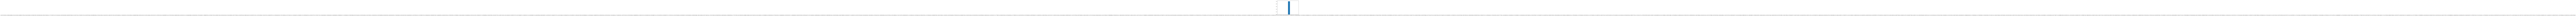

In [161]:
plt.hist(predictions)
plt.show()

In [365]:
def predict(data, rows=441):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data_array)

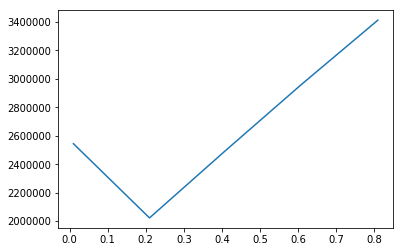

Cost is minimized near a cutoff of: 0.21000000000000002 for a cost of: 2022000


In [369]:
cutoffs = np.arange(0.01, 1, 0.2)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 6000], [58000, 6000]]) * 
                               pd.crosstab(index=test_data['Attrition_Yes'], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))